# MNIST

In [1]:
import numpy as np
import pandas as pd

from IPython.display import display

# models/classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# tools for pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# tools for classifier evaluation
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score

# tools for plotting
import matplotlib.pyplot as plt

# for nan values checking
import math

## Global config

In [2]:

models = {
    "GaussianNB" : GaussianNB(),
    "DecisionTreeClassifier" : DecisionTreeClassifier(max_depth=None, min_samples_leaf=2, random_state=42),
    "SVC" : SVC(C=10, kernel="poly", random_state=42),
    "KNeighbours": KNeighborsClassifier(n_neighbors=3, weights="distance"),
    "LogisticRegression": LogisticRegression(penalty="none", random_state=42)
}

tuned_models = {
            "GaussianNB": GaussianNB(),
            "DecisionTreeClassifier" : DecisionTreeClassifier(),
            "SVC" : SVC(),
            "KNeighbours": KNeighborsClassifier(),
            "LogisticRegression": LogisticRegression()
}

hyper_params = {
    "DecisionTreeClassifier" : ["max_depth", "min_samples_leaf"],
    "SVC" : ["C", "kernel"],
    "KNeighbours": ["weights", "n_neighbors"],
    "LogisticRegression": ["C", "penalty"]
}

normal_scores_8x8 = np.arange(5)
tuned_scores_8x8 = np.arange(5)


## Load data

In [3]:
mnist_28x28_train = np.load("mnist_28x28_train.npy")
mnist_8x8_train = np.load("mnist_8x8_train.npy")
train_labels = np.load("train_labels.npy")

mnist_28x28_test = np.load("mnist_28x28_test.npy")
mnist_8x8_test = np.load("mnist_8x8_test.npy")

## Helpers

In [4]:
def plot_results(scores, bar_1, bar_2):
    
    scores_1 = scores[0]
    scores_2 = None
    
    if len(scores) == 2:
        scores_2 = scores[1]
   
    
    labels = ['NB', 'Tree', 'SVC', 'K-NN', 'LR']
        
    x = np.arange(len(labels))
    
    fig, ax = plt.subplots()
    
    width = 0.35
    rects1 = ax.bar(x - width/2, scores_1, width, label=bar_1)
    rects2 = ax.bar(x + width/2, scores_2, width, label=bar_2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Scores by algorithm and dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()
    
def setModelParams(target, source):
    for name, value in source.get_params().items():
        target.get_params()[name] = value
        

setModelParams(LogisticRegression(), LogisticRegression())

##  Data exploration

### Question 1
Hint: `plt.imshow`

,Dataset,Size,Features
0,mnist_8x8,3750,64
1,mnist_28x28,3750,784



Picture number 0 in the train sets is of class:  1


'\nThe first images from the datasets are of digit 1. However, we can see the first one contains\nmore generalized information, while the one is more detailed, it contains a\nlot more features and thus provides more information.\n\nBecause we have a large training set - with 3750 samples, this allows for more features\nto be used for training the classifiers. As a result, the presumption is that the\nlarger dataset will on average perform better.\n\n'

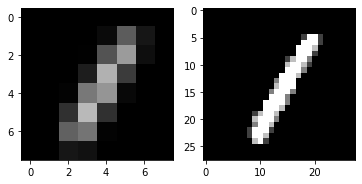

In [5]:
dataset_sizes = pd.DataFrame([
    ["mnist_8x8", mnist_8x8_train.shape[0], mnist_8x8_train.shape[1] * mnist_8x8_train.shape[2]],
    ["mnist_28x28", mnist_28x28_train.shape[0], mnist_28x28_train.shape[1] * mnist_28x28_train.shape[2]]],
    columns = ["Dataset", "Size", "Features"]
)

display(dataset_sizes)

print()

i = 0
print("Picture number {} in the train sets is of class: ".format(i), train_labels[i])

f, axarr = plt.subplots(1,2)
axarr[0].imshow(mnist_8x8_train[i], cmap='gray', vmin=0, vmax=255)
axarr[1].imshow(mnist_28x28_train[i], cmap='gray', vmin=0, vmax=255)
    
"""
The first images from the datasets are of digit 1. However, we can see the first one contains
more generalized information, while the one is more detailed, it contains a
lot more features and thus provides more information.

Because we have a large training set - with 3750 samples, this allows for more features
to be used for training the classifiers. As a result, the presumption is that the
larger dataset will on average perform better.

"""

##  Data Preparations

### Question 1

In [6]:
# Data Pre-processing
"""
Because we want every sample to be a feature vector in order to work with the
classifiers, we will reshape the data in both datasets.

No data cleaning is needed, because the dataset does not contain missing or null values.
However, there is lots of redundant data and to get rid of it, we will perform PCA
dimensionlaty reduction. In this way, we also significantly decrease the training time
of algorithms like SVM and K-NN.

The data has feature scaling, meaning all have values in the range [0, 255], and so
there is little need to normalize the data for K-Nearest Neighbours, Logistic Regression or SVM. 

"""

# Reshape the data
mnist_28 = mnist_28x28_train.reshape(mnist_28x28_train.shape[0], 28 * 28)
mnist_8 = mnist_8x8_train.reshape(mnist_8x8_train.shape[0], 8 * 8)

# Dimensionality Reduction with PCA
pca_8 = PCA(0.95)
pca_28 = PCA(0.95)

# Reduce 8x8
mnist_28_reduced = pca_8.fit_transform(mnist_28)

# Reduce 28x28
mnist_8_reduced =  pca_28.fit_transform(mnist_8)

dict = {
    "Dataset": ["28x28", "28x28 PCA reduced", "8x8", "8x8 reduced"],
    "Components": [28*28, mnist_28_reduced.shape[1], 8*8, mnist_8_reduced.shape[1]],
    "Variance %": [100, pca_28.n_components * 100, 100, pca_8.n_components * 100]
}
comp = pd.DataFrame(dict)
display(comp)


,Dataset,Components,Variance %
0,28x28,784,100.0
1,28x28 PCA reduced,148,95.0
2,8x8,64,100.0
3,8x8 reduced,22,95.0


### Question 1

In [7]:
## Experiments
"""
We will divide the train set into two, leaving 30% of the data as out validation set. We
will also use a standard 5-fold cross-validation to get an average estimate of our classifiers'
performance. In this way, we also ensure that the whole dataset will be used for testing, leading
to more correct classifier evaluation.

"""

"\nWe will divide the train set into two, leaving 30% of the data as out validation set. We\nwill also use a standard 5-fold cross-validation to get an average estimate of our classifiers'\nperformance. In this way, we also ensure that the whole dataset will be used for testing, leading\nto more correct classifier evaluation.\n\n"

### Question 2

In [19]:
# Hyper-Parameter Tuning

index = -1

# Create a data splitter for the outer CV

for name, model in tuned_models.items():
    
    # Update index of the score to update
    index += 1
    
    # Skip Naive Bayes
    if name == "GaussianNB":
        tuned_scores_8x8[index] = normal_scores_8x8[0]
        continue
    
    best_model = None
    best_score = 0
    best_params = None

    print(name, ":")
    cv_outer = StratifiedKFold(n_splits=10)
    splits = cv_outer.split(mnist_8, train_labels)


    for i, split in enumerate(splits):

        # Get the splitted training and testing set
        train_i, test_i = split[0], split[1]
        trainX, testX, trainY, testY = (mnist_8_reduced[train_i], mnist_8_reduced[test_i], train_labels[train_i], train_labels[test_i])
            
        # Fit the model -> Get best hyper params in the inner CV
        model.fit(trainX, trainY)
        est = model.best_estimator_
        print(est)
                    
        # Test it using the testing set in the outer CV
        predictions = est.predict(testX)
            
        # Check whether it has the best performnce by now
        score = accuracy_score(testY, predictions)
        if score > best_score:
                    
            best_score = score
            best_model = est
            best_params = model.best_params_
            
            # Update the best params for the model
            
            
        print("Split {i}: ".format(i=i), score)
        
    tuned_models[name] = best_model
    print(tuned_models[name])
    tuned_scores_8x8[index] = best_score
    
    print()


"""
To perform hyper-parameter tuning, we use double cross validation. To do this, we first use
a StratifiedKFold object to make 5 splits of our training mnist dataset into a training and a validation set.
Also, we use a GridSearchCV object to perform the inner cross validation. Then for every model and every 
split of the data, we fit the split's train data into the GridSearchCV object, which automatically performs the inner
cross validation for every combination of the provided values for the model's hyper-parameters.
The best performing combinations for every split are then compared in the outer CV with the split's validation set.

The best perforing combination in the outer CV is used to tune the model.

We perform this for both the large and the compressed mnist training datasets.

"""

for model in tuned_models:
    print(model)

DecisionTreeClassifier :
DecisionTreeClassifier(max_depth=50, min_samples_leaf=5.96551724137931e-06)
Split 0:  0.744
DecisionTreeClassifier(min_samples_leaf=1.6206896551724138e-06)
Split 1:  0.728
DecisionTreeClassifier(max_depth=14, min_samples_leaf=2.2413793103448275e-06)
Split 2:  0.736
DecisionTreeClassifier(max_depth=50, min_samples_leaf=5.96551724137931e-06)
Split 3:  0.7093333333333334


GaussianNB : 8x8:  0.8479999999999999, 28x28:  0.8397333333333334
DecisionTreeClassifier : 8x8:  0.748, 28x28:  0.7128
SVC : 8x8:  0.9389333333333333, 28x28:  0.9551999999999999
KNeighbours : 8x8:  0.9256, 28x28:  0.9293333333333333
LogisticRegression : 8x8:  0.8797333333333335, 28x28:  0.8170666666666666


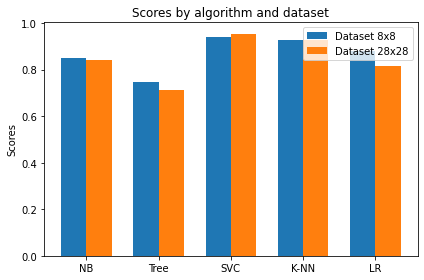

'\nThe bar plot below shows the average accuracy of the five algorithms cross-validates\nusing 90% train data and 10% validation data.\nAs we can see, the performance is from worse to best:\nDecision Tree < Naive Bayes < Logistic Regression < K-Nearest Neighbours < SVC\n\nThe plot also shows that on average:\n    SVC and K-NN perform better with the larger dataset\n    GaussianNB, Decision Tree and Logistic Regression perform better with the compressed dataset. \n\n    \n'

In [12]:
# Now we will fit the models using

scores_8x8 = np.zeros(5) 
scores_28x28 = np.zeros(5)

index = 0

for name, model in models.items():
    print("{n} : ".format(n=name), end='')
   
    scores_8x8[index] = np.mean(cross_validate(model, mnist_8_reduced, train_labels, cv=10)['test_score'])
    scores_28x28[index] = np.mean(cross_validate(model, mnist_28_reduced, train_labels, cv=10)['test_score'])
    
    print("8x8: ", scores_8x8[index], end=', ')
    print("28x28: ", scores_28x28[index])
    
    index += 1

normal_scores_8x8 = scores_8x8    
plot_results([scores_8x8, scores_28x28], "Dataset 8x8", "Dataset 28x28")

'''
The bar plot below shows the average accuracy of the five algorithms cross-validates
using 90% train data and 10% validation data.
As we can see, the performance is from worse to best:
Decision Tree < Naive Bayes < Logistic Regression < K-Nearest Neighbours < SVC

The plot also shows that on average:
    SVC and K-NN perform better with the larger dataset
    GaussianNB, Decision Tree and Logistic Regression perform better with the compressed dataset. 

    
'''

In [13]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression
param_grid_lr = { 
    'C': [0.1, 1, 5, 10],
    'penalty': ['none', 'l1', 'l2']
    }


# SVC
param_grid_svc = { 
    'C': [ 1, 5, 10, 20],
    'kernel': ['rbf', 'poly', 'sigmoid']
}
    
# Decision Tree
param_grid_dt = {
    'max_depth': [ 14, 40, 50, None],
    'min_samples_leaf': np.linspace(0.000001, 0.00001 , 30, endpoint=True)
}

# K-Nearest Neighbours
param_grid_knn = {
    'n_neighbors': [3, 4, 5, 6, 7, 10, 50, 70, 100],
    'weights': ['uniform', 'distance']
}

tuned_models['LogisticRegression'] = GridSearchCV(LogisticRegression(), param_grid_lr, refit=True, verbose=0)
tuned_models['SVC'] = GridSearchCV(SVC(), param_grid_svc, refit=True, verbose=0)
tuned_models['DecisionTreeClassifier'] = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, refit=True, verbose=0)
tuned_models['KNeighbours'] = GridSearchCV(KNeighborsClassifier(), param_grid_knn, refit=True, verbose=0)


### Question 4 

In [ ]:
# Plot the performance of the 8x8 dataset models / tuned_models

perf_normal = normal_scores_8x8
perf_tuned = np.zeros(5)

index = 0

print(tuned_models)

for name, tuned_model in tuned_models.items():
    print(name)
    if name == "GaussianNB":
        perf_tuned[index] = normal_scores_8x8[index]
        index += 1
        continue
    perf_tuned[index] = np.mean(cross_validate(tuned_model, mnist_8_reduced, train_labels, cv=4)['test_score'])
    index += 1                  
                                
plot_results([scores_8x8, perf_tuned], "Baseline", "Tuned")
                                
# Effect of tuning - results and differences
"""
On the plot below we can see the results of testing our algorithms on the smaller PCA-reduced dataset with and without 
hyper-parameter tuning. Unfortunately, none of the algorithms can be 
"""


### Question 5

In [11]:
# Comparison of performance with the two datasets
"""

"""


### Question 6

In [37]:
# Pre-process data of the test 28x28 set
mnist_28x28_test = mnist_28x28_test.reshape(mnist_28x28_test.shape[0], 28 * 28)

test_dataset = pca_28.transform(mnist_28x28_test)


best_algorithm = None

prediction = best_algorithm.model(test_dataset)

pd.DataFrame(prediction).to_csv("GROUP_classes_problem_mnist.txt", index=False, header=False)